# Image based Cell Phenotying using EfficientNet

In [3]:
import pickle
import numpy as np
import os
import time
import gc
import matplotlib.pyplot as plt

from itertools import cycle
import pandas as pd
from PIL import Image
from scipy import ndimage, misc

In [39]:
!pip install pytorch-ignite

     |████████████████████████████████| 264 kB 27.8 MB/s            


In [41]:
from tqdm import tqdm_notebook as tqdm

import torch
import ignite
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")


In [5]:
path = 'HCT-116_1.pickle'
x = pickle.load(open(path,"rb"))

In [6]:
size = x.shape

In [7]:
size

(508, 1, 75, 75, 4)

In [8]:
size[0]

508

In [19]:
from PIL import Image as im

In [33]:
img = [x[0].astype(float)]
img = np.array(img)

In [34]:
img = img.squeeze()

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
print(torch.__version__, ignite.__version__, os.cpu_count())
if device == 'cuda': print(torch.cuda.get_device_name())

1.8.1 0.4.10 4
Tesla T4


In [46]:
use_amp = True if device == 'cuda' else False
training = True if device == 'cuda' else False

In [49]:
training

True

In [50]:
# install NVIDIA Apex if needed to support mixed precision training
if use_amp and training:
    try:
        from apex import amp
    except ImportError:
#         !git clone https://github.com/NVIDIA/apex
#         !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/
        !pip install  -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/*/*/NVIDIA-apex*
        from apex import amp

In [52]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

[2022-11-29 15:16:38.256 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:50 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-29 15:16:38.291 pytorch-1-8-gpu-py3-ml-g4dn-xlarge-60bd0d07a83be181dcf7335baae2:50 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


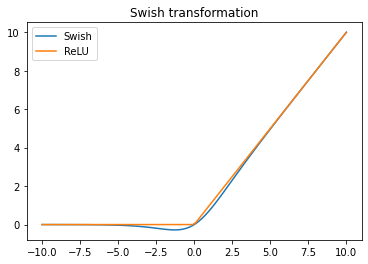

In [53]:
import matplotlib.pylab as plt
%matplotlib inline

d = torch.linspace(-10.0, 10.0)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
_ = plt.legend()

In [58]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x

In [59]:
from torch.nn import functional as F

class MBConv(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                self._drop_connect(x)
            x += z
        return x

In [61]:
from collections import OrderedDict
import math


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
                
        list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        list_channels = [self._setup_channels(c) for c in list_channels]
                
        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        # Define head
        self.head = nn.Sequential(
            nn.Conv2d(list_channels[-2], list_channels[-1], 
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
            Swish(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(list_channels[-1], num_classes)
        )

        self.apply(init_weights)
        
    def forward(self, x):
        f = self.stem(x)
        f = self.blocks(f)
        y = self.head(f)
        return y

In [62]:
import torchvision.utils as vutils

import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle

In [63]:
le = preprocessing.LabelEncoder()
le.fit_transform(['HCT-116', 'HL60', 'JURKAT', 'LNCAP', 'MCF7', 'PC3', 'THP-1', 'USOS'])

array([0, 1, 2, 3, 4, 5, 6, 7])